<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/torch/IntroDifferentiableProgramming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 微分可能プログラミングで始める機械学習
Differentiable Programming for Beginners: Machine Learning Essentials


1.	機械学習，入出力の例から関数を作る技術．例：画像認識（画像，物体の種類），
2.	損失の最小化問題．損失関数の勾配で降下．関数のモデルの修正の反復．
3.	線形回帰の最小二乗法は解の公式があるけど，ロジスティック回帰は？対数損失？もしモデルが複雑だったら？
4.	導関数の実装が面倒くさい．そんなあなたに微分可能プログラミング♪
5.	入力・出力・損失の計算まで書いたら，合成微分の要領で勾配計算はフレームワークにお任せ．
6.	合成微分？計算グラフで説明するよ．
7.

## はじめに

機械学習（machine learning）の目的は，データから正確な予測値を計算することです．入力されたデータから予測値を計算する関数をモデルと呼びます．モデルの予測の悪さを評価する関数を損失関数（loss function）といいます．学習とは，損失関数がなるべく小さくなるようにモデルを調整することです．最近の機械学習では，調節できるモデルの設計と損失関数の最小化を，微分可能プログラミング（differentiable programming）によって実現しています．

## モデルの設計と最適化

機械学習のモデルは，与えられた入力に対して適切な予測を出力する数学的な表現です．人工知能を実現しているニューラルネットワークも，入力から予測値を計算する関数に過ぎません．出力の予測値は入力 $\vec x$ の関数 $f(\vec x)$ です．いくつか複数の数値をまとめてひとつの入力として扱いたいことがあるので，$\vec x$ は $m_\mathrm{in}$ 次元ベクトルとします．

関数としてモデルを設計しましょう．一次関数は，比較的単純で，しかも応用の範囲が広いモデルです．
$$ f(\vec x)=\vec w\cdot\vec x+b = w_1 x_1+w_2 x_2+\cdots+w_{m_\mathrm{in}}x_{m_\mathrm{in}}+b\qquad(1)$$
$\vec w$ と $b$ はそれぞれ「重み（weight）」と「バイアス（bias）」と呼ばれるモデル変数です．$f(\vec x)$ が正確な予測値を出力するためには， $\vec w$ と $b$ を適切な値に調整しておく必要があります．

PyTorchは深層学習で最も人気のあるフレームワークのひとつであり，微分可能プログラミングの入門者にもお勧めです．
PyTorchを使って式(1)の関数を実装する一例を示します．

In [ ]:
import torch
def model(x):
    return x.matmul(w.t()) + b

$m_\mathrm{in}=1$ のとき（$x=x_1$） ，方程式 $y=f(x)$ は傾き $w_1$，$y$ 切片 $b$ の直線を表します．例えば，バネにおもりをつるすと，バネはおもりの質量に比例した長さだけ伸びます．自然長を加えたバネ全体の長さ $y$ は，質量 $x$ の一次関数 $f(x)=w_1x+b$ で予測できます．これがバネ長のモデルです．

あとは，$w_1$ と $b$ の値が決まればモデルの完成です．実際におもりをつるして調べたデータと合うように決めましょう．質量 `x` を変えながら長さ `y` を6通り測りました．6個の1次元データを，サイズ `[6,1]` の `torch.Tensor` 型で表します．

In [ ]:
x = torch.tensor([[0.1, 0.3, 0.5, 0.7, 0.8, 1.0]]).T
y = torch.tensor([[0.8, 1.4, 2.0, 1.6, 2.9, 3.5]]).T
print(type(x), x.shape)

<class 'torch.Tensor'> torch.Size([6, 1])


 質量0.7のときのバネ長1.6は測定の間違いでしょうか．何にせよ，このデータから傾き $w_1$ と切片 $b$ を推定できそうです．直線を当てはめる最小二乗法をご存じの方は，公式を使って確認してください．

 ここでは，微分可能プログラミングの真価が発揮されるPyTorchの最適化機能を使うことにします．まず，モデル $f(\vec x)$ による予測値の誤差の総和を損失関数（loss function）として定義します．最小二乗法では平均二乗誤差が使われますが，ここでは，予測値 `f` と実測値 `y` の差の絶対値の和を損失関数とします．

In [ ]:
def loss(f, y):
    return torch.abs(f-y).sum()

推定したい $m_\mathrm{in}$ 次元ベクトル $\vec w$ と実数 $b$ を，Tensor型の変数 `w` と `b` とし，初期値を適当な乱数にしておきます．損失関数が小さくなるように勾配（gradient）を使って `w` と `b` の値を修正したいので，`requires_grad=True` と設定します．

In [ ]:
m_in, m_o = 1, 1
w = torch.rand(m_o, m_in, requires_grad=True)
b = torch.rand(m_o, requires_grad=True)

`w` と `b` を修正する最適化のアルゴリズムには Adam を採用します．`lr` は学習率（learning rate）と呼ばれ，修正する大きさの目安です．小さすぎると収束までに時間がかかり，大きすぎると損失関数が小さくならずに発散します．

In [ ]:
optimizer = torch.optim.Adam([w, b], lr=0.01)

それでは，`w` と `b` の修正を1000回繰り返してみましょう．予測値 `model(x)` と実測値 `y` から算出した損失を `l` とします．`optimizer.zero_grad()` で勾配をゼロに初期化してから，`l.backward()` を実行して損失関数の勾配を計算し，`optimizer.step()` で `w` と `b` を修正します．

In [ ]:
for epoch in range(1000):
    l = loss(model(x), y)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print("epoch =", epoch, ", loss =", l.item())
print("w =", w, "\nb =", b)

epoch = 0 , loss = 7.617441177368164
epoch = 200 , loss = 2.933465003967285
epoch = 400 , loss = 1.5576844215393066
epoch = 600 , loss = 1.0023789405822754
epoch = 800 , loss = 1.0195766687393188
w = tensor([[3.0003]], requires_grad=True) 
b = tensor([0.4995], requires_grad=True)


損失が約1まで小さくできています．傾きと切片はそれぞれ約3と0.5と推定されました．グラフで確認しましょう．質量0.7のときのバネ長は，1.6ではなく2.6だったようですね．

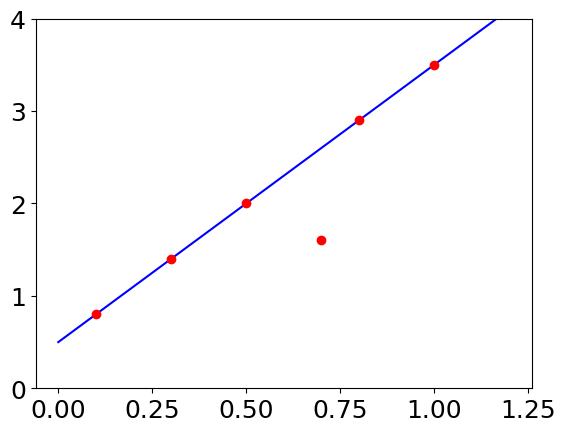

In [ ]:
import matplotlib.pyplot as plt
xs = torch.linspace(0.0, 1.2, 20)
plt.plot(xs, model(xs.unsqueeze(1)).detach(), "b")
plt.plot(x, y, "ro")
plt.ylim([0, 4]);plt.tick_params(labelsize=18)

## 自動微分の仕組み

微分可能プログラミングは，導関数を正確に数値計算する技術です．微分可能な関数が組み合わさった複雑な合成関数でも，その導関数の値（微分係数）が合成関数の微分公式に従って自動的に計算されます．この仕組みは自動微分（automatic differentiation）として知られており，計算グラフ（computational graph）と呼ばれる計算の表現が基盤になっています．

一次関数を $f=wx+b$ のように計算し，$y$ と比べた二乗誤差を $l=(f-y)^2$ と計算するとします．$w=3.0$，$b=0.5$ のとき，$x=0.7$，$y=1.6$ から二乗誤差を計算する過程は，下図のように表せます．このようなデータの流れと演算の表現を計算グラフといいます．

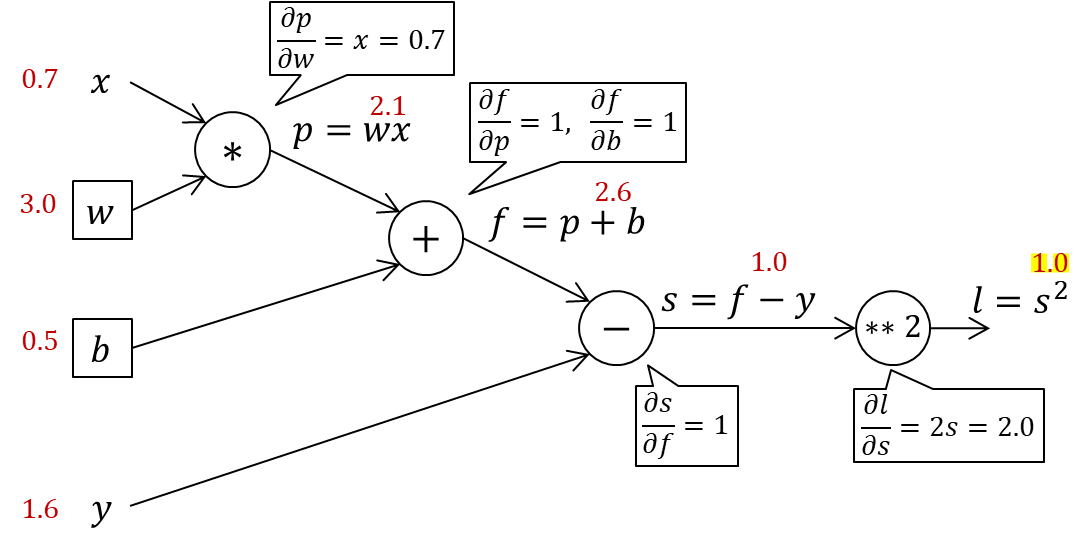

図の左から右に計算が進み，$l=1.0$ が算出されます．この計算過程を前向き計算（forward computation または forward pass）と呼びます．計算グラフの節 "$*$"，"$+$"，"$-$"，"$**2$" はそれぞれ，積，和，差，二乗の演算を表します．微分可能プログラミングに使われる演算や関数は，前向き計算だけでなく，偏導関数を計算する機能も内蔵しています．例えば，二乗の演算 "**2" は，入力された $s$ から $s^2$ を算出するだけでなく，図中の吹き出しに示すように，偏導関数 $2s$ を計算する機能を備えています．この機能を組み合わせて，合成微分を実現します．例えば，損失 $l$ を $w$ と $b$ の関数と見なし，損失関数の勾配 $\nabla l=[\partial l/\partial w,\partial l/\partial b]$ を計算できます．合成関数の偏導関数を計算する連鎖律（chain rule）から次式が成り立ちます．
$$\frac{\partial l}{\partial w}=\frac{\partial l}{\partial s}\frac{\partial s}{\partial f}\frac{\partial f}{\partial p}\frac{\partial p}{\partial w}=2.0\cdot 1\cdot 1\cdot 0.7=1.4$$
$$\frac{\partial l}{\partial b}=\frac{\partial l}{\partial s}\frac{\partial s}{\partial f}\frac{\partial f}{\partial p}\frac{\partial p}{\partial b}=2.0\cdot 1\cdot 1\cdot 1=2.0$$
具体的には，まず，前向き計算をしながら計算グラフを組み立てます．グラフの各節は計算した値を記憶しています．次に，出力側から左にさかのぼりながら，図中の吹き出しに示す偏導関数を次々に計算します．この過程は逆伝播（backward propagation）と呼ばれます．通称，バックプロップ（backpropagation）です．勾配の計算に必要な偏微分係数がすべて得られるまでさかのぼれば計算終了です．PyTorchで実行してみます．

In [ ]:
import torch

w = torch.tensor(3.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)
f = w * x[3] + b
l = (f - y[3])**2

l.backward()
print(w.grad, b.grad)

tensor(1.4000) tensor(2.0000)


偏微分係数が得られていますね．`l.backward()` は `requires_grad=True` を設定した計算グラフの葉（leaf）に関する `l` の偏微分係数を計算します．替わりに `torch.autograd.grad(l, [w, b])` と書くと，指定した `[w, b]` に関する勾配が得られます．

In [ ]:
import torch

w = torch.tensor(3.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)

f = w * x[3] + b
l = (f - y[3])**2
print(l)

#print(torch.autograd.grad(l, [f, w, b]))
dl = torch.autograd.grad(l, [w, b])
print(dl)

tensor([1.0000], grad_fn=<PowBackward0>)
(tensor(1.4000), tensor(2.0000))


微分可能プログラミングで実現されているものは，計算グラフに基づく自動微分です．PyTorchや現在のTensorFlowは，計算グラフを意識しなくても，書かれた式の手順に従って前向き計算を進めながら計算グラフを構築します．これをdefine-by-runといいます．合成関数の微分公式に従って導関数が正確に計算されるので，微小な $\varepsilon$ で変化率 $(l(w+\varepsilon,b)-l(w,b))/\varepsilon$ を近似計算する数値微分とは異なります．

## 人工ニューラルネットワーク
[`torch.nn`](https://pytorch.org/docs/stable/nn.html)は，多層のニューラルネットワークを構成するための部品や損失関数等を多数提供しています．モデル変数は最適化しやすい初期値に設定されています．式(1)の一次関数モデルを $m_\mathrm{o}$ 個集めると，$m_\mathrm{in}$ 入力 $m_\mathrm{o}$ 出力の全結合層（fully-connected layer; fc）になり，`nn.Linear` を用いて定義できます．平均二乗誤差を測る損失関数は `nn.MSELoss`，差の絶対値の平均は `nn.L1Loss` です．


In [ ]:
import torch.nn as nn
model = nn.Linear(in_features=m_in, out_features=m_o)
loss = nn.L1Loss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1000):
    l = loss(model(x), y)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print("epoch =", epoch, ", loss = ", l.item())

print("w =", model.weight.detach(), "\nb = ", model.bias.detach())

epoch = 0 , loss =  1.4530192613601685
epoch = 200 , loss =  0.5955283641815186
epoch = 400 , loss =  0.3705691397190094
epoch = 600 , loss =  0.17081022262573242
epoch = 800 , loss =  0.16741037368774414
w = tensor([[2.9973]]) 
b =  tensor([0.4984])


`nn.Sequential` を使うと，数珠繋ぎの多層構造をもつモデルを簡単に作れます．例えば，$m_\mathrm{h}$ 次元の中間層をもつ $m_\mathrm{in}=2$ 入力 $m_\mathrm{o}=1$ 出力の3層ニューラルネットワークは，
```python
m_in, m_h, m_out = 2, 3, 1
model = nn.Sequential(nn.Linear(m_in, m_h), nn.ReLU(), nn.Linear(m_h, m_o))
```
のように定義できます．[`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)は，[活性化関数（activation function）](https://en.wikipedia.org/wiki/Activation_function)の一種です．一次関数よりも柔軟な，折れ線や曲線，曲面などを表せる非線形関数のモデルを作りたいときに使われます．

機械学習では，実数値を予測する問題を回帰（regression），種類を予測する問題を識別（classification）といいます．$m_\mathrm{o}$ 個の実数を予測する回帰では `nn.MSELoss` などの損失関数でモデルを学習します．識別問題の場合は，$m_\mathrm{o}$ 個の各種類の可能性を表す確率をモデルに予測させるため，学習には交差エントロピー（cross entropy）と呼ばれる損失関数 `nn.CrossEntropyLoss` が使われます．`nn.Softmax` 関数を使うと，$m_\mathrm{o}$ 個のモデルの出力を，合計が1の確率になるように換算できます．もし，検査薬のように陰陽で分類する二値問題ならば，$m_\mathrm{o}=1$ として `nn.BCEWithLogitsLoss` で学習できます．

####例題： [この例と同様の識別器をPyTorchで作ります．](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=3&seed=0.27615&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

In [ ]:
m_in, m_h, m_o = 2, 3, 1
model = nn.Sequential(nn.Linear(m_in, m_h),
                      nn.ReLU(),
                      nn.Linear(m_h, m_o))
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
)


In [ ]:
from sklearn.datasets import make_circles
x, y = make_circles(n_samples=150, random_state=0,
                    noise=0.1, factor=0.3)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

loss = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1000):
    l = loss(model(x), y)
    optim.zero_grad()
    l.backward()
    optim.step()
    if epoch % 200 == 0:
        print("epoch =", epoch, ", loss = ", l.item())

epoch = 0 , loss =  0.6989659667015076
epoch = 200 , loss =  0.309428334236145
epoch = 400 , loss =  0.0760224387049675
epoch = 600 , loss =  0.0329081155359745
epoch = 800 , loss =  0.019975582137703896


<Figure size 640x480 with 0 Axes>

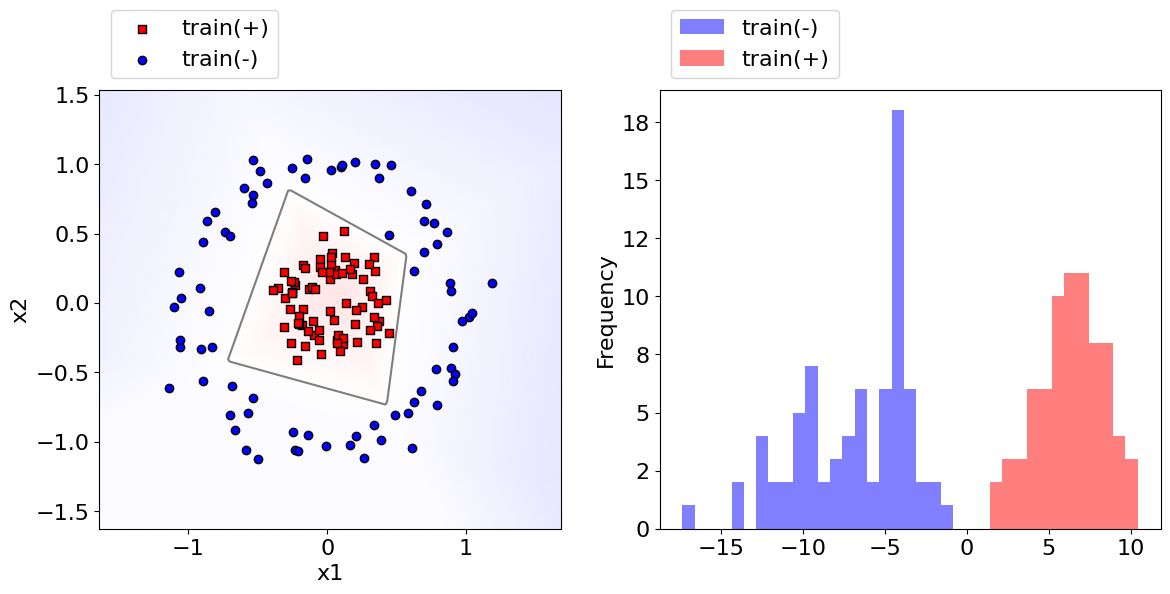

In [ ]:
#@title 識別結果を図示します．
!wget -q -N https://gist.githubusercontent.com/tsakai-g/1920bc185be0c497579968e00a9b3674/raw/e9716a16ee6a701dad030b6f94195485b3b7cb2c/plot2cls.py
%run plot2cls.py
plot2cls(x.detach(), y.detach().view(-1), lambda x: model(torch.tensor(x, dtype=torch.float32)).detach().view(-1)).plot_clf()

詳細は割愛しますが，データの規模が大きいときは，`torch.utils.data.DataLoader` を使い，小分けにしたデータごとにモデル変数を修正することを反復します．また，学習が終わったモデルは，学習に使っていないデータに対する予測の正しさを調べて評価してください．

全結合層のみの多層ニューラルネットワークは多層パーセプトロン（multilayer perceptron; MLP）とも呼ばれます．理論上，3層MLPは中間層の次元 $m_h$ を増やすことで，任意の関数 $f:\mathbb{R}^{m_\mathrm{in}}\rightarrow \mathbb{R}^{m_\mathrm{o}}$ を任意の誤差で近似できます．しかし，対象のデータによっては，出力の予測に役立つ特徴量をMLPよりも上手に入力データから算出できるニューラルネットワークが考案されています．

畳み込みニューラルネットワーク（convolutional neural network; CNN）は，画像の特徴抽出に適しています．複雑に見える画像でも，局所的には単純な模様が組み合わさっていて，徐々に全体が構成されています．1つの畳み込み層 [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) では，フィルタカーネル（filter kernel）と呼ばれる $C$ 種類の局所的な模様を入力から調べ，それぞれの模様の分布を表す特徴マップ（feature map）を $C$ 枚出力します．$C$ はチャネル数と呼ばれ，数十から数百程度の数に設定します．バッチ正規化層[`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) で特徴マップの強弱を整え，顕著な特徴を選ぶ活性化関数を間に挟みながら畳み込み層を重ねつつ，途中で数回，[`nn.Maxpool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) などのプーリング層（pooling layer）で特徴マップを縮小するのが基本的なCNNの構成です．画像認識では，畳み込み層のフィルタカーネルなどを学習可能なモデル変数とし，CNNを最適化します．



- 複雑な画像処理をする関数でも，部品を組み合わせて容易に実装できる．
- オプティマイザで学習できる．モデル変数を最適化するアルゴリズムを自作しなくてよい．
- 大量のデータがなくても，学習済みのモデルを簡単に流用できる．転移学習．


- NVIDIAのGPUを搭載したコンピュータがあれば，前向き計算にも最適化にもGPUが使える．GPUプログラミングは不要．
- nnモジュールをはじめ，初等関数，FFT，特異値分解など，実に様々な関数が導関数と共に実装されています．深層学習専用の道具ではなく，理工学の分野で幅広く利用価値を秘めている．



どこがすごい？ 前向き計算だけを記述すれば，勾配に基づき損失関数を最小にする最適化の数値計算ができる．勾配を計算する式を導出したり実装する必要はない．PyTorchなどは最適化アルゴリズム optimizer もともに提供されているので，最適化すら自分で実装する必要がない．最小化のアルゴリズムを設計するのが難しそうな損失関数でも，微分可能プログラミングで実装できるなら，利用できる．もちろん，勾配を用いて最小解にたどり着きにくいような損失関数は，実装してoptimizerを適用できるとしても，お望みにの最小解が必ず得られるとは限らない．数値計算でなるべく最小解が求まりやすい損失関数を設計すべきだし，初期値や optimizerの選択，学習率の設定など，試行錯誤が必要になる．

前向き計算も最適化もすべてGPUを容易に使える．

In [5]:
import torch
from torchvision import models
# https://pytorch.org/vision/stable/models.html
model = models.vgg16_bn(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

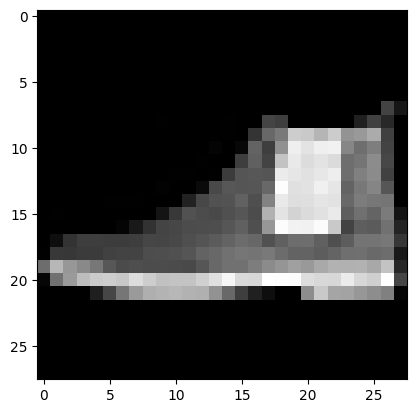

In [61]:
from torchvision import datasets
# [MNIST](http://yann.lecun.com/exdb/mnist/)
#tvds = datasets.MNIST('./data', download=True, train=True);
# [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)
tvds = datasets.FashionMNIST('./data', download=True, train=True);

# uri = "https://otamatone.jp/cms/wp-content/uploads/2019/09/190421_otamatone71638-300x300.jpg"
# import imageio
# cimg = imageio.imread(uri)
# img = cimg.mean(axis=2)

Ximages = tvds.data.numpy()
img = Ximages[111]

import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')
plt.show()

Input:  <class 'torch.Tensor'> torch.Size([1, 1, 28, 28])
Output: <class 'torch.Tensor'> torch.Size([1, 1, 28, 28])


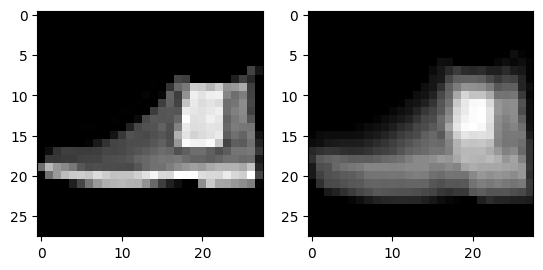

In [71]:
kernel = [[ 0, 1, 0, 0, 0],
          [ 0, 0, 1, 0, 0],
          [ 0, 0, 1, 0, 0],
          [ 0, 0, 1, 0, 0],
          [ 0, 0, 0, 1, 0]]

import torch
kernel = torch.tensor(kernel).expand(1,1,5,5)
kernel = kernel / kernel.sum()
model = torch.nn.Conv2d(1, 1, 5, bias=False, padding='same')
model.weight = torch.nn.Parameter(kernel.float())

in_img = torch.tensor(img).unsqueeze(0).unsqueeze(0).float() / 255.0
out_img = model(in_img).detach()

# (n, channels, height, width)
print("Input: ", type(in_img), in_img.shape)
print("Output:", type(out_img), out_img.shape)

plt.subplot(1,2,1)
plt.imshow(in_img[0,0].detach(), cmap='gray')

plt.subplot(1,2,2)
plt.imshow(out_img[0,0], cmap='gray')
plt.show()

<ipython-input-72-30523f776d57>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_img_pred = torch.tensor(out_img, requires_grad=True)


epoch = 0 , loss =  0.001250005792826414
epoch = 200 , loss =  5.509025768901665e-08
epoch = 400 , loss =  1.279235384288313e-08
epoch = 600 , loss =  2.415277435829921e-07
epoch = 800 , loss =  1.1409616718083271e-07


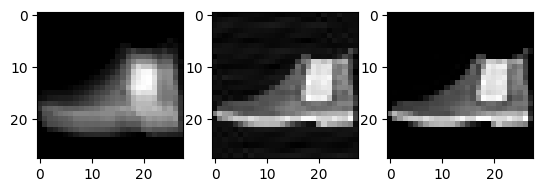

In [72]:
#in_img_pred = torch.zeros_like(out_img, requires_grad=True)
in_img_pred = torch.tensor(out_img, requires_grad=True)

loss = torch.nn.MSELoss()
optim = torch.optim.Adam([in_img_pred], lr=0.1)

for epoch in range(1000):
    l = loss(model(in_img_pred), out_img)
    optim.zero_grad()
    l.backward()
    optim.step()
    if epoch % 200 == 0:
        print("epoch =", epoch, ", loss = ", l.item())

plt.subplot(1,3,1)
plt.imshow(out_img[0,0], cmap='gray')

plt.subplot(1,3,2)
plt.imshow(in_img_pred[0,0].detach(), cmap='gray')

plt.subplot(1,3,3)
plt.imshow(in_img[0,0], cmap='gray')
plt.show()

In [74]:
#sobelx = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]]).float().expand(1,1,3,3)
#sobely = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]).float().expand(1,1,3,3)
sobelx = torch.tensor([[1, -1], [0, 0]]).float().expand(1,1,2,2)
sobely = torch.tensor([[1,0], [-1, 0]]).float().expand(1,1,2,2)

def tvloss(img):
#    tv = (torch.nn.functional.conv2d(img, sobelx).square() + torch.nn.functional.conv2d(img, sobely).square() + 1e-5).sqrt().sum()
    tv = (torch.nn.functional.conv2d(img, sobelx).abs() + torch.nn.functional.conv2d(img, sobely).abs()).sum()
    return tv

<ipython-input-76-ad785942f228>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_img_pred = torch.tensor(out_img, requires_grad=True)


epoch = 0 , loss =  0.005657440982758999 , mse = 0.001250005792826414 , tv = 0.004407435189932585
epoch = 200 , loss =  0.004585062153637409 , mse = 0.0003193831362295896 , tv = 0.00426567904651165
epoch = 400 , loss =  0.00457425694912672 , mse = 0.000323179381666705 , tv = 0.004251077771186829
epoch = 600 , loss =  0.004571413621306419 , mse = 0.00032213382655754685 , tv = 0.004249279852956533
epoch = 800 , loss =  0.004572645295411348 , mse = 0.000326151232002303 , tv = 0.0042464942671358585
epoch = 1000 , loss =  0.004570083227008581 , mse = 0.00032582879066467285 , tv = 0.004244254436343908
epoch = 1200 , loss =  0.004565209615975618 , mse = 0.00032572762575000525 , tv = 0.004239481873810291
epoch = 1400 , loss =  0.004565036855638027 , mse = 0.00032657833071425557 , tv = 0.004238458350300789
epoch = 1600 , loss =  0.0045692711137235165 , mse = 0.00032871257280930877 , tv = 0.004240558482706547
epoch = 1800 , loss =  0.004568756558001041 , mse = 0.0003283167025074363 , tv = 0.0042

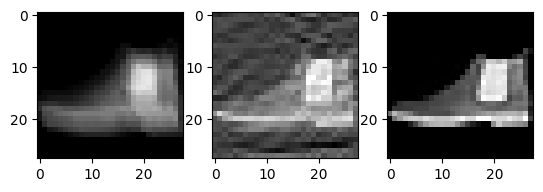

In [76]:
#in_img_pred = torch.zeros_like(out_img, requires_grad=True)
in_img_pred = torch.tensor(out_img, requires_grad=True)

loss = torch.nn.MSELoss()
lambda_tv = 1e-4
optim = torch.optim.Adam([in_img_pred], lr=0.01)

for epoch in range(2000):
    out_img_pred = model(in_img_pred)
    mse = loss(out_img_pred, out_img)
    tv = lambda_tv * tvloss(out_img_pred)
    l = mse + tv
    optim.zero_grad()
    l.backward()
    optim.step()
    if epoch % 200 == 0:
        print("epoch =", epoch, ", loss = ", l.item(), ", mse =", mse.item(), ", tv =", tv.item())

plt.subplot(1,3,1)
plt.imshow(out_img[0,0], cmap='gray', vmax=1.0)

plt.subplot(1,3,2)
plt.imshow(in_img_pred[0,0].detach(), cmap='gray', vmax=1.0)

plt.subplot(1,3,3)
plt.imshow(in_img[0,0], cmap='gray', vmax=1.0)
plt.show()

In [ ]:
#@title グラフを描くクラス `plot2cls` を定義します（理解不要）．
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm as tsn
import warnings
warnings.filterwarnings("ignore")#, category=np.VisibleDeprecationWarning)

class plot2cls:
    def __init__(self, X_train, y_train=None, decision_function=None, X_val=None, y_val=None, dx=0.02, cmap=plt.cm.bwr, xlim=None, ylim=None, margin=0.5, levels={0.0:'-'}, colors='k', bins=None, alpha={'train': 1.0, 'val': 0.2}):
        self.data = {'train': {'X': X_train, 'y': y_train}, 'val': {'X':X_val, 'y': y_val}}
        self.clf = decision_function
        if X_val is not None:
            xlim = [X_val[:, 0].min(), X_val[:, 0].max()]
            ylim = [X_val[:, 1].min(), X_val[:, 1].max()]
        else:
            xlim = [float('inf'), - float('inf')]
            ylim = [float('inf'), - float('inf')]
        xlim[0] = min(xlim[0], X_train[:, 0].min()) - margin
        xlim[1] = max(xlim[1], X_train[:, 0].max()) + margin
        ylim[0] = min(ylim[0], X_train[:, 1].min()) - margin
        ylim[1] = max(ylim[1], X_train[:, 1].max()) + margin
        if bins is None:
            bins = len(X_train) // 4
        self.layout = {'dx': dx, 'cmap': cmap, 'xlim': xlim, 'ylim': ylim, 'levels': levels, 'colors': colors, 'bins': bins, 'alpha': alpha}


    def _data_layout(self, ax, bbox_to_anchor, loc):
        ax.set_xlim(self.layout['xlim'][0], self.layout['xlim'][1])
        ax.set_ylim(self.layout['ylim'][0], self.layout['ylim'][1])
        #plt.axis('tight')
        ax.set_xlabel('$x_1$', fontsize=16)
        ax.set_ylabel('$x_2$', fontsize=16)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.set_aspect('equal')
        #ax.legend(bbox_to_anchor=(1.5,1.0), loc="upper right", fontsize=16, frameon=True)
        ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc, fontsize=16, frameon=True)
        if self.data['val']['X'] is not None and self.data['val']['y'] is not None:
            ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc, fontsize=16, frameon=True, ncol=2)
            ax.get_legend().legendHandles[-2].set_color('k')
            ax.get_legend().legendHandles[-1].set_color('k')
        plt.tight_layout()


    def _scatter(self, ax, c={'train': ['r', 'b'], 'val': ['k', 'k']}, marker=['s', 'o']):
        for mode in ['train', 'val']:
            alpha = self.layout['alpha'][mode]
            if self.data[mode]['y'] is not None:
                X, y = self.data[mode]['X'], self.data[mode]['y']
                ax.scatter(X[y>0, 0], X[y>0, 1], c=c[mode][0],  marker=marker[0], cmap=self.layout['cmap'], edgecolors='k', label=mode+'($1$)', alpha=alpha)
                ax.scatter(X[y<=0, 0], X[y<=0, 1], c=c[mode][1], marker=marker[1], cmap=self.layout['cmap'], edgecolors='k', label=mode+'($0$)', alpha=alpha)
            elif self.data[mode]['X'] is not None:   # unlabeled data
                X = self.data[mode]['X']
                ax.scatter(X[:, 0], X[:, 1], c=c[mode][0],  marker=marker[0], cmap=self.layout['cmap'], edgecolors='k', label='unlabeled', alpha=alpha)


    def _put_data(self, ax, levels):
        if levels is None:
            levels = self.layout['levels']
        if self.clf is not None:
            xx, yy = np.meshgrid(np.arange(self.layout['xlim'][0], self.layout['xlim'][1], self.layout['dx']), np.arange(self.layout['ylim'][0], self.layout['ylim'][1], self.layout['dx']))

            # Show prediction by color by assigning a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
            Z = self.clf(np.c_[xx.ravel(), yy.ravel()])
            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            norm = tsn(vmin=np.minimum(Z[:].min(),-1e-6), vcenter=0, vmax=np.maximum(Z[:].max(),1e-6))
            if self.layout['cmap'] is not None:
                ax.pcolor(xx, yy, Z, cmap=self.layout['cmap'], alpha=0.1, edgecolors=None, norm=norm)
            lvls = list(levels.keys())
            linestyles = list(levels.values())
            ax.contour(xx, yy, Z, levels=lvls, colors=self.layout['colors'], linestyles=linestyles, alpha=0.5)

        self._scatter(ax)


    def plot_data(self, bbox_to_anchor=(1,0), loc="lower left"):
        ax = plt.figure(figsize=(8,8))
        ax = plt.axes()
        self._put_data(ax, levels=None)
        self._data_layout(ax, bbox_to_anchor=bbox_to_anchor, loc=loc)


    def _hist_layout(self, ax, bbox_to_anchor, loc, xlabel):
        ax.set_xlabel(xlabel, fontsize=16)
        ax.set_ylabel("Frequency", fontsize=16)
        #ax.axis('tight')
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        #plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.0f'))
        from matplotlib.ticker import FormatStrFormatter
        ax.yaxis.set_major_formatter(FormatStrFormatter('%1.0f'))
        #ax.set_aspect(1)
        ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc, fontsize=16, frameon=True)
        if self.data['val']['X'] is not None and self.data['val']['y'] is not None:
            ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc, fontsize=16, frameon=True, ncol=2)
            #ax.legend(ncol=2)
        plt.tight_layout()


    def _make_hist(self, ax):
        if self.clf is None:
            return
        pred = self.clf(self.data['train']['X'])
        gt = self.data['train']['y']
        ax.hist( [ pred[gt>0], pred[gt<=0] ], bins=self.layout['bins'], histtype='stepfilled', density=False, alpha=0.5, color=['r', 'b'], label=['train($1$)', 'train($0$)'])
        if self.data['val']['X'] is not None and self.data['val']['y'] is not None:
            pred = self.clf(self.data['val']['X'])
            gt = self.data['val']['y']
            ax.hist( [ pred[gt>0], pred[gt<=0] ], bins=self.layout['bins'], histtype='stepfilled', density=False, alpha=0.3, color=['r', 'b'], label=['val($1$)', 'val($0$)'])


    def plot_hist(self, loc="lower left", bbox_to_anchor=(0,1), xlabel=""):
        ax = plt.figure(figsize=(6,6))
        ax = plt.axes()
        self._make_hist(ax)
        self._hist_layout(ax,bbox_to_anchor, loc, xlabel)


    def plot_clf(self, loc="lower left", bbox_to_anchor=(0,1), xlabel="", levels=None):
        if self.clf is None:
            return

        fig, axes = plt.subplots(figsize=(6,6), nrows=1, ncols=1)
        #fig, axes = plt.subplots(nrows=1, ncols=2)
        ax = axes#[0]
        self._put_data(ax, levels=levels)
        self._data_layout(ax, bbox_to_anchor, loc)

        #fig.set_figwidth(12)
        #fig.set_figheight(8)
        #ax = axes[1]
        #self._make_hist(ax)
        #self._hist_layout(ax, bbox_to_anchor, loc, xlabel)

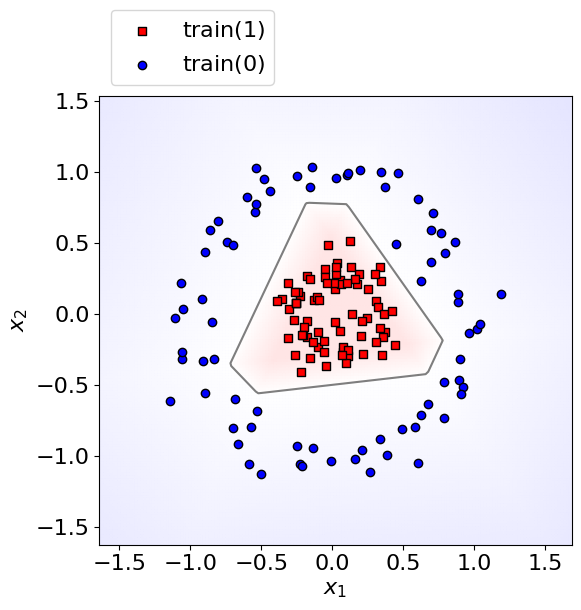

In [ ]:
plot2cls(x.detach(), y.detach().view(-1), lambda x: model(torch.tensor(x, dtype=torch.float32)).detach().view(-1)).plot_clf()
#plt.savefig("./circles.svg")

In [ ]:
import torch
n = 1
model = nn.Linear

w = torch.tensor([])
def f(x):
    return w * x + w

x = torch.tensor([[167.1],[175.],[180.5],[172.1],[159.3],[186.9],[163.]], requires_grad=True)
y = torch.tensor([[60],[64],[68],[64],[59],[70],[61]], requires_grad=True)

model =

f = x*y+(x+y)
print(f)

df = torch.autograd.grad(f, [x,y])
print(df)

In [ ]:
import torch
x = torch.tensor([[0.1, 0.3, 0.5, 0.7, 0.8, 1.0],[0.1, 0.3, 0.5, 0.7, 0.8, 1.0]]).T

n = 2
#w = torch.rand(n+1, requires_grad=True)
w = torch.tensor([[1.5, 1.5]])
b = torch.tensor(0.5)
print(w.shape)
print(x.shape)
print(model(x))

torch.Size([1, 2])
torch.Size([6, 2])
tensor([[0.8000],
        [1.4000],
        [2.0000],
        [2.6000],
        [2.9000],
        [3.5000]])


In [ ]:
#@title 2次元データ X を y で色分けしてプロットする関数 plot2d(X, y) を定義します．

import numpy as np
from matplotlib.colors import TwoSlopeNorm as tsn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def plot2d(X, y=None, title="", xlabel="", ylabel="", axis="on", zorder=0, s=20, linewidths=0.5, margin=0.5, ax=None, dpi=100, fontsize=12):
    if X.shape[1] != 2: return

    if ax is None:
        _, ax = plt.subplots(dpi=dpi)

    plt.subplots_adjust(wspace=0.5)

    xlim = [X[:, 0].min() - margin, X[:, 0].max() + margin]
    ylim = [X[:, 1].min() - margin, X[:, 1].max() + margin]

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title, fontsize=fontsize)
    #ax.set_title(title, y=-0.15, pad=-6)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.axis(axis)
    ax.set_aspect(1)
    ax.tick_params(labelsize=fontsize)

    if y is not None:
        classes = np.unique(y)
        for yi in classes:
            ax.scatter(
                *X[y == yi].T,
                marker=f"${yi}$",
                s=s,
                linewidths=linewidths,
                color=plt.cm.tab10(yi), #Paired(yi),
                alpha=0.8,
                zorder=zorder,
            )
    else:
        ax.scatter(*X.T, marker=".", s=s, color='k', alpha=0.8, zorder=2)

    return ax

from matplotlib import pyplot as plt

まず、機械学習の基本として、トレーニングデータとテストデータの概念を説明しましょう。トレーニングデータは、モデルの学習に使用するデータセットです。モデルは、トレーニングデータを入力として受け取り、そのデータに適合するように自動的に学習します。その後、テストデータを使用してモデルの予測性能を評価します。

損失関数は、モデルの予測と実際の正解との誤差を計算するために使用されます。損失関数は、予測結果と正解の差を定量化し、その値を最小化するようにモデルを調整する役割を果たします。この最小化のプロセスは、微分可能プログラミングによって行われます。

微分可能プログラミングでは、モデルを構成する関数や演算子が微分可能であることが重要です。微分可能な関数を使用することで、損失関数の勾配（グラディエント）を計算し、その勾配の情報を使用してモデルのパラメータを更新します。この勾配降下法と呼ばれる手法によって、損失を最小化する最適なパラメータを見つけることができます。

最近の機械学習では、微分可能プログラミングを利用してモデルの設計と最適化を行うためのフレームワークやツールが多数開発されています。これらのツールを使うことで、初学者でも機械学習のモデルを構築し、データからの学習と予測を行うことができます。

機械学習は、大量のデータや複雑な問題に対して非常に強力な手法です。ただし、適切なデータの準備やモデルの選択、パラメータの調整など、いくつかのポイントに留意する必要があります。しかし、微分可能プログラミングの利用により、初学者でも機械学習の基本を理解し、実際にモデルを構築して活用することができます。

# of X = 400


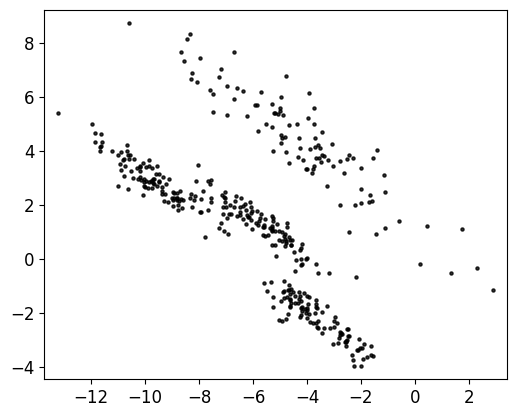

In [ ]:
# Example (b): four non-spherical blobs (k=4)
from sklearn.datasets import make_blobs
A = [[1.2, -0.6], [-0.6, 0.8]]
n_samples = [100,100,100,100]
X, y = make_blobs(n_samples=n_samples, cluster_std=[2,0.8,0.8,0.8], random_state=1)
X = X.dot(A)
X = torch.tensor(X)
#@title データを表示します．
print("# of X =", len(X))
plot2d(X)
plt.show()

In [ ]:
import torch
import torch.distributions as D
k = 4
dim = 2
a = torch.ones(k, requires_grad=True)
mu = torch.randn(k, dim, requires_grad=True)*4
sigma = torch.eye(dim).reshape((1, dim, dim)).repeat(k, 1, 1)
sigma.requires_grad_(True)

#print(a,mu,sigma)
def loss(x):
    mx = D.Categorical(a**2)
    cmp = D.MultivariateNormal(mu, sigma.matmul(sigma))
#    cmp = D.Normal(mu, sigma)
    gmm = D.MixtureSameFamily(mx, cmp)
    return gmm.log_prob(x).mean()

In [ ]:
optimizer = torch.optim.Adam([a, mu, sigma], lr=0.0003)
for epoch in range(10000):
    l = loss(X)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 100 == 0: print("epoch =", epoch, ", loss = ", l.item())
print("a =", a, "and mu =", mu)

ValueError: ignored

a = tensor([1., 1., 1., 1.], requires_grad=True) and mu = tensor([[-4.6639e-03,  3.2886e-01],
        [-1.0972e+00,  4.5062e+00],
        [-4.8111e-01,  9.5601e-01],
        [ 9.3110e+00, -6.4307e-01]], grad_fn=<MulBackward0>)


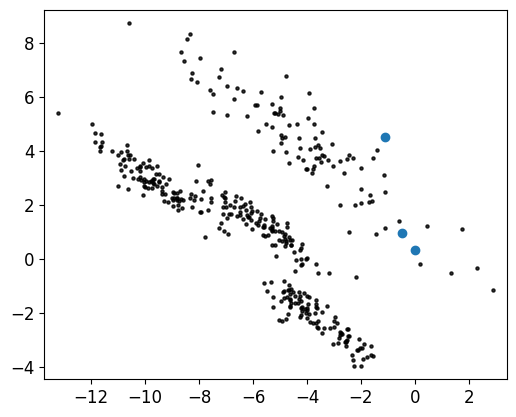

In [ ]:
print("a =", a, "and mu =", mu)
plot2d(X)
plt.plot(mu.detach()[:,0], mu.detach()[:,1], "o")
plt.show()